<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Bounding-Box" data-toc-modified-id="Bounding-Box-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Bounding Box</a></span></li><li><span><a href="#Label" data-toc-modified-id="Label-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Label</a></span></li></ul></li><li><span><a href="#Calculate-Bounding-Box" data-toc-modified-id="Calculate-Bounding-Box-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate Bounding Box</a></span></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#Using-Mayavi" data-toc-modified-id="Using-Mayavi-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Using Mayavi</a></span></li><li><span><a href="#Using-Matplotlib" data-toc-modified-id="Using-Matplotlib-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Using Matplotlib</a></span></li></ul></li><li><span><a href="#Orientation-angle" data-toc-modified-id="Orientation-angle-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Orientation angle</a></span></li><li><span><a href="#Validation-Pipeline" data-toc-modified-id="Validation-Pipeline-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Validation Pipeline</a></span></li><li><span><a href="#Data-Overview" data-toc-modified-id="Data-Overview-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data Overview</a></span></li><li><span><a href="#Backup" data-toc-modified-id="Backup-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Backup</a></span><ul class="toc-item"><li><span><a href="#Create-PCD-Files" data-toc-modified-id="Create-PCD-Files-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Create PCD Files</a></span></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#3D-Plot-using-matplotlib" data-toc-modified-id="3D-Plot-using-matplotlib-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>3D Plot using matplotlib</a></span></li><li><span><a href="#3D-Plot-using-pptk" data-toc-modified-id="3D-Plot-using-pptk-7.2.2"><span class="toc-item-num">7.2.2&nbsp;&nbsp;</span>3D Plot using pptk</a></span></li></ul></li></ul></li></ul></div>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import string
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import collections
import seaborn as sns 
# import pcl
import ipywidgets as widgets
from IPython.display import display
import h5py

from crowd_tracker_lidar3d.loader import load_data_to_dataframe
from crowd_tracker_lidar3d.plot_tools import plot_pointcloud3d, draw_point_cloud, show_projections
from crowd_tracker_lidar3d.preprocessing import rotate_pcl, df_apply_rot, return_ground_points, \
                                                remove_ground_points, standardize_data, translate_height,\
                                                add_polar_coord, rotate_pcl
from crowd_tracker_lidar3d.cluster_utils import return_cluster_and_noise_points, plot_xy_cluster_results, \
                                                plot_3d_cluster_results
from crowd_tracker_lidar3d.hdf5_util import load_h5
import matplotlib.pyplot as plt 

In [5]:
# Helper Function to save plots 
def save_fig(fig, path, extension='.pdf'):
    save_dir = path + extension
    fig.savefig(save_dir, bbox_inches='tight')  

## Load Data

In [8]:
os.getcwd()

'/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/jupyter_nbs'

### Bounding Box 

In [11]:
DATA_DIR = os.path.dirname(os.path.abspath(''))
DATA_DIR = os.path.join(DATA_DIR, "data/med/annotated_boundbox/")
print(DATA_DIR)

/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/


In [12]:
for folder in sorted(os.listdir(DATA_DIR)):
    print(folder)
    path = os.path.join(DATA_DIR, folder) 
    data_files = [str(f) for f in sorted(os.listdir(path)) if f.endswith('.h5')] 
    break

person166_1


In [13]:
frame = data_files[20]
f = os.path.join(path, frame)
data, bbox = load_h5(f)
print(f)

/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/person166_1/frame116.h5


In [14]:
centroid, h, w, l = bbox[0:3], bbox[3], bbox[4], bbox[5] 

### Label 

In [9]:
LABEL_DIR = os.path.dirname(os.path.abspath(''))
LABEL_DIR = os.path.join(LABEL_DIR, "data/med/hdf5/")
for folder in sorted(os.listdir(LABEL_DIR)):
    print(folder)
    path = os.path.join(LABEL_DIR, folder) 
    data_files = [str(f) for f in sorted(os.listdir(path)) if f.endswith('.h5')] 
    break
frame = data_files[20]
f = os.path.join(path, frame)
print(f)
temp_data, label = load_h5(f)
mask = np.where(label)
template = temp_data[mask]

person166_1
/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/hdf5/person166_1/frame116.h5


In [10]:
template.shape

(337, 4)

## Calculate Bounding Box 

In [7]:
def calc_3d_box(bbox): 
    x, y, z, h, w, l = bbox[:6]
    box8 = np.array(
        [
            [
                x + w / 2,
                x + w / 2,
                x - w / 2,
                x - w / 2,
                x + w / 2,
                x + w / 2,
                x - w / 2,
                x - w / 2,
            ],
            [
                y - l / 2,
                y + l / 2,
                y + l / 2,
                y - l / 2,
                y - l / 2,
                y + l / 2,
                y + l / 2,
                y - l / 2,
            ],
            [
                z - h / 2,
                z - h / 2,
                z - h / 2,
                z - h / 2,
                z + h / 2,
                z + h / 2,
                z + h / 2,
                z + h / 2,
            ],
        ]
    )
    return box8.T

In [8]:
def draw_gt_boxes3d(
    gt_boxes3d,
    fig,
    color=(1, 1, 1),
    line_width=1,
    draw_text=False,
    text_scale=(1, 1, 1),
    color_list=None,
    label=""
):
    """ Draw 3D bounding boxes
    Args:
        gt_boxes3d: numpy array (n,8,3) for XYZs of the box corners
        fig: mayavi figure handler
        color: RGB value tuple in range (0,1), box line color
        line_width: box line width
        draw_text: boolean, if true, write box indices beside boxes
        text_scale: three number tuple
        color_list: a list of RGB tuple, if not None, overwrite color.
    Returns:
        fig: updated fig
    """
    num = len(gt_boxes3d)
    for n in range(num):
        b = gt_boxes3d[n]
        if color_list is not None:
            color = color_list[n]
        if draw_text:
            mlab.text3d(
                b[4, 0],
                b[4, 1],
                b[4, 2],
                label,
                scale=text_scale,
                color=color,
                figure=fig,
            )
        for k in range(0, 4):
            # http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
            i, j = k, (k + 1) % 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )

            i, j = k + 4, (k + 1) % 4 + 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )

            i, j = k, k + 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )
    # mlab.show(1)
    # mlab.view(azimuth=180, elevation=70, focalpoint=[ 12.0909996 , -1.04700089, -2.03249991], distance=62.0, figure=fig)
    return fig

In [ ]:
def generate_corners3d(h,w,l,ry):
    """
    generate oriented bounding box representation for 3D object
    :ry rotation angle around y axis (-pi,pi)
    :return corners_3d: (8, 3) corners of box3d in camera coord
    """
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]

    R = np.array([[np.cos(ry), 0, np.sin(ry)],
                  [0, 1, 0],
                  [-np.sin(ry), 0, np.cos(ry)]])
    corners3d = np.vstack([x_corners, y_corners, z_corners])  # (3, 8)
    # transpose and rotate around heading angle 
    corners3d = np.dot(R, corners3d).T
    corners3d = corners3d + self.pos
    return corners3d

In [18]:
box8 = calc_3d_box(bbox)
print(box8.shape)
gt_box = np.reshape(box8, (-1,8,3))
print(gt_box.shape)

(8, 3)
(1, 8, 3)


## Visualizations

### Using Mayavi
Inspired by authors of [Frustum PointNet](https://github.com/charlesq34/frustum-pointnets/blob/master/mayavi/viz_util.py).

In [ ]:
from mayavi import mlab

In [13]:
mlab.init_notebook()

Notebook initialized with ipy backend.


In [31]:
def draw_lidar_simple(pc, color=None):
    ''' Draw lidar points. simplest set up. '''
    fig = mlab.figure(figure=None, bgcolor=(0,0,0), fgcolor=None, engine=None, size=(1600, 1000))
    if color is None: 
        color = pc[:,2]
    #draw points
        # draw points
    mlab.points3d(
        pc[:, 0],
        pc[:, 1],
        pc[:, 2],
        color,
        color=None,
        mode="point",
        colormap="gnuplot",
        scale_factor=1,
        figure=fig,
    )
    #draw origin
    mlab.points3d(0, 0, 0, color=(1,1,1), mode='sphere', scale_factor=0.2)
    #draw axis
    axes=np.array([
        [2.,0.,0.,0.],
        [0.,2.,0.,0.],
        [0.,0.,2.,0.],
    ],dtype=np.float64)
    
    mlab.plot3d([0, axes[0,0]], [0, axes[0,1]], [0, axes[0,2]], color=(1,0,0), tube_radius=None, figure=fig)
    mlab.plot3d([0, axes[1,0]], [0, axes[1,1]], [0, axes[1,2]], color=(0,1,0), tube_radius=None, figure=fig)
    mlab.plot3d([0, axes[2,0]], [0, axes[2,1]], [0, axes[2,2]], color=(0,0,1), tube_radius=None, figure=fig)
    mlab.view(azimuth=180, elevation=70, focalpoint=[ 12.0909996 , -1.04700089, -2.03249991], distance=30.0, figure=fig)
    return fig

In [ ]:
fig = draw_lidar_simple(data)

In [ ]:
fig

In [21]:
fig = draw_gt_boxes3d(gt_box, fig)

### Using Matplotlib
Code inspired by [this repo](https://github.com/navoshta/KITTI-Dataset/blob/master/kitti-dataset.ipynb).

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

axes_limits = [
    [-2, 4], # X axis range
    [-1, 2], # Y axis range
    [-0.5, 3]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_bboxes_in_data(dataset, gt_boxes3d, plot=True):
    """
    Displays the (ground truth) bounding boxes corresponding to the detection/label within the scatter 
    plot of the LiDAR data within 4 plots (one in 3D, and 3 projections).
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    gt_boxes3d      : numpy nd array with bbox defined by its 8 vertices (in 3d spatial coordinates)
    """
    
    # Size of point markers in plots
    point_size = 0.3

    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None, plot=plot):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(dataset[:, axes]), s=point_size, c=dataset[:, 3], cmap='viridis')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
#         User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        
        num = len(gt_boxes3d)
        for n in range(num):
            b = gt_boxes3d[n].T
            draw_box(ax, b, axes=axes, color='r')
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(10, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=axes_limits[2])
    if plot:
        plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(10, 15))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0)', 
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0)', 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0)', 
        axes=[1, 2] # Y and Z axes
    )
    if plot: 
        plt.show()
    return f

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


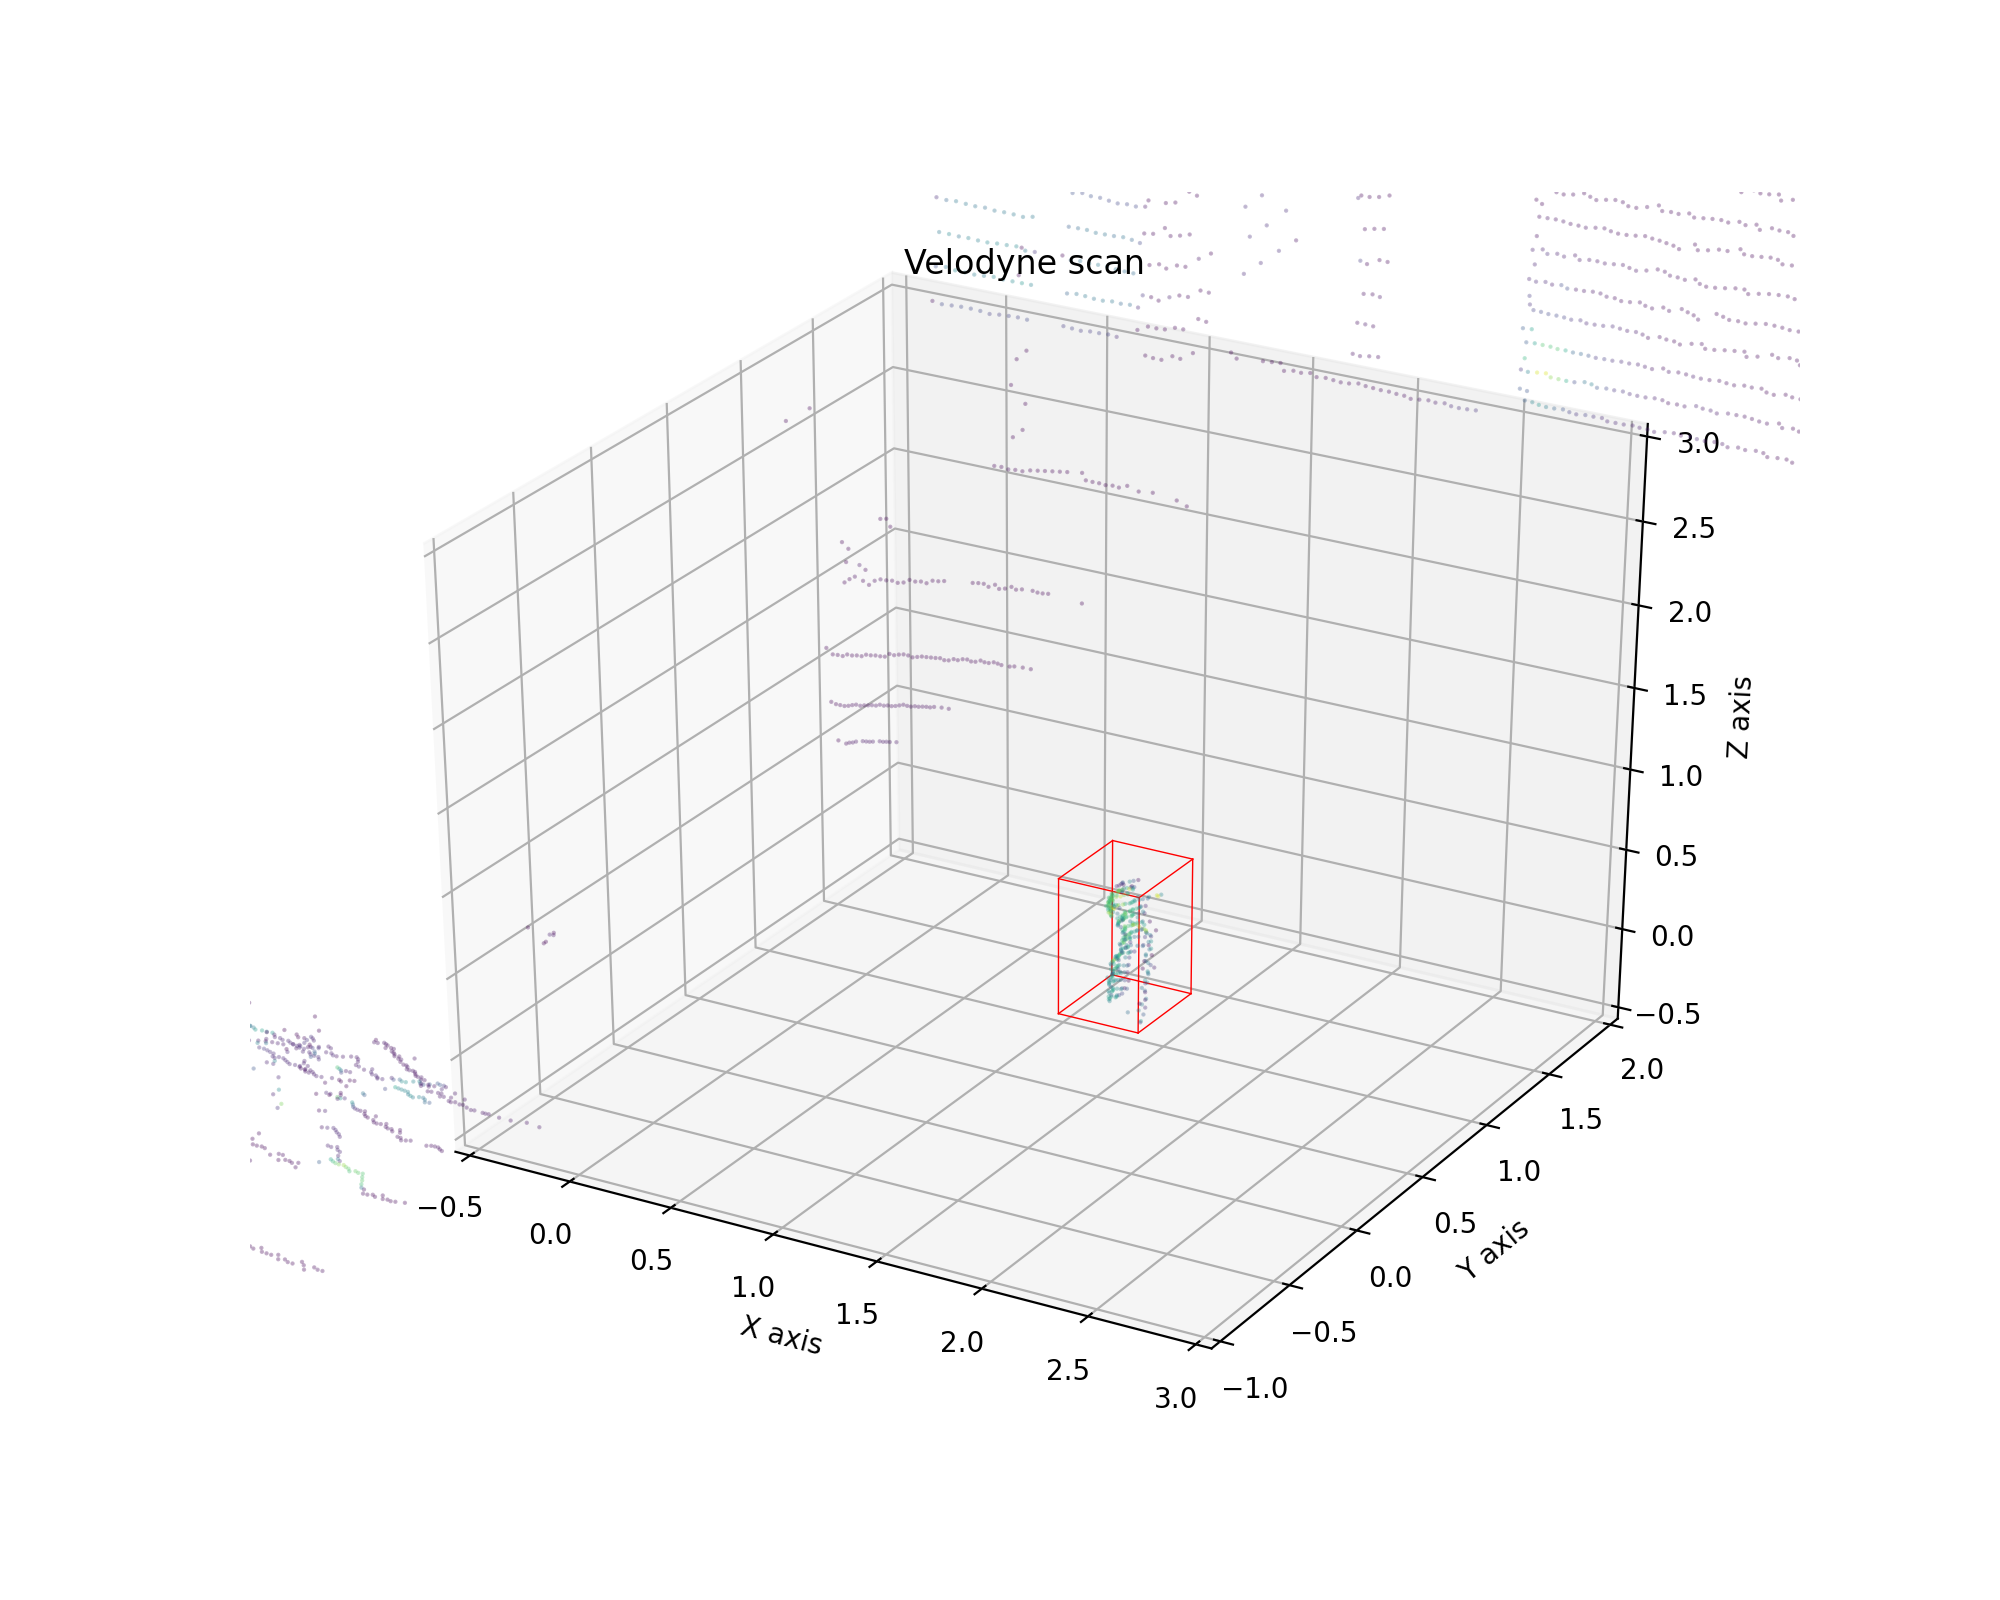

<IPython.core.display.Javascript object>


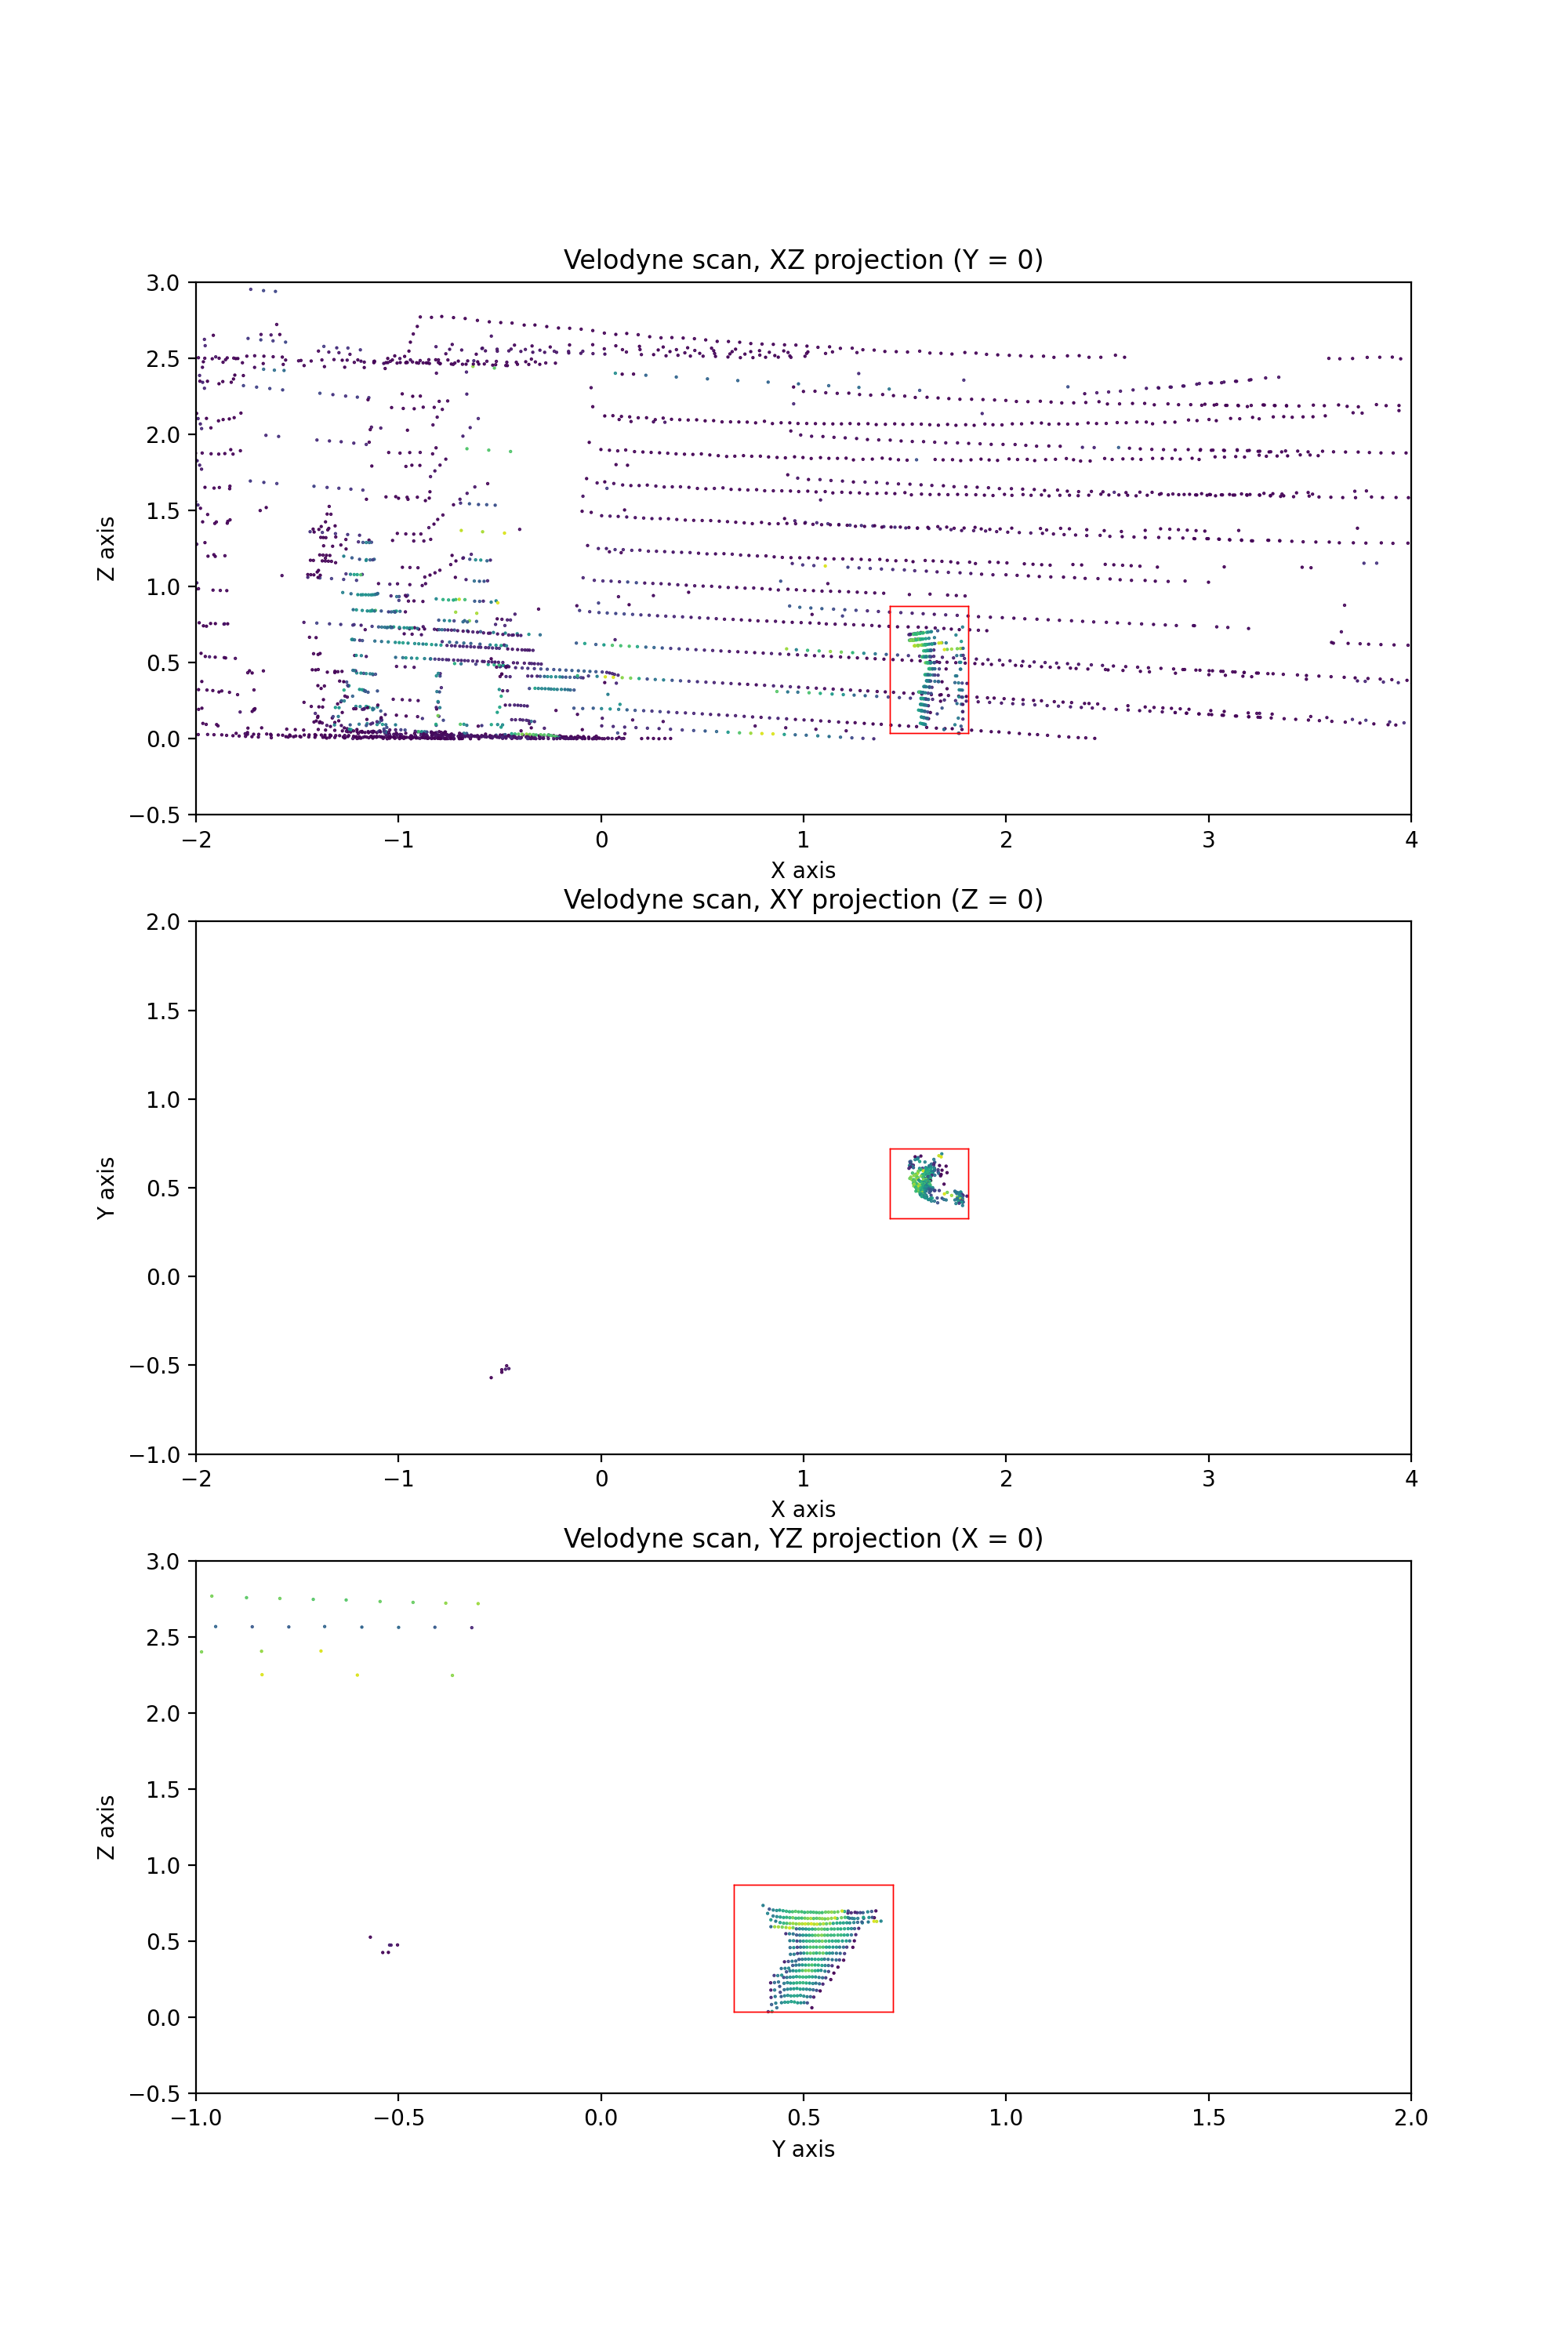

In [19]:
detections_proj = display_bboxes_in_data(data, gt_box)

In [30]:
def save_fig_in_folder(fig, path, keyword=None):    
    SAVE_DIR = os.path.join(path, 'plots')
    print('Saving figure in {}'.format(SAVE_DIR))

    if os.path.exists(SAVE_DIR):
        pass # File has already been processed
    else:
        os.makedirs(SAVE_DIR)
    frame_name = str.rstrip(frame, '.h5')
    if keyword: 
        frame_name = frame_name + '_' + keyword
    save_fig(fig, os.path.join(SAVE_DIR, frame_name), extension='.png')

## Orientation angle 
Look for principal component in x,y-plane. Eigenvalues of covariance matrix = principle components $\rightarrow$ eigenvector with largest eigenvalue of the covariance matrix = direction along which data has the largest variance.

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()
# Standardizing the features
# X_temp = StandardScaler().fit_transform(template[:,0:2])
X = StandardScaler().fit_transform(temp_data[:,0:2])
X_temp = X[mask]

# Apply PCA 
pca = PCA(n_components=1)
pca.fit(X_temp)

print(pca.explained_variance_ratio_)
print(pca.components_)
print(pca.mean_)

[0.70478827]
[[ 0.751068   -0.66022485]]
[-0.3308866  0.0352975]


<IPython.core.display.Javascript object>


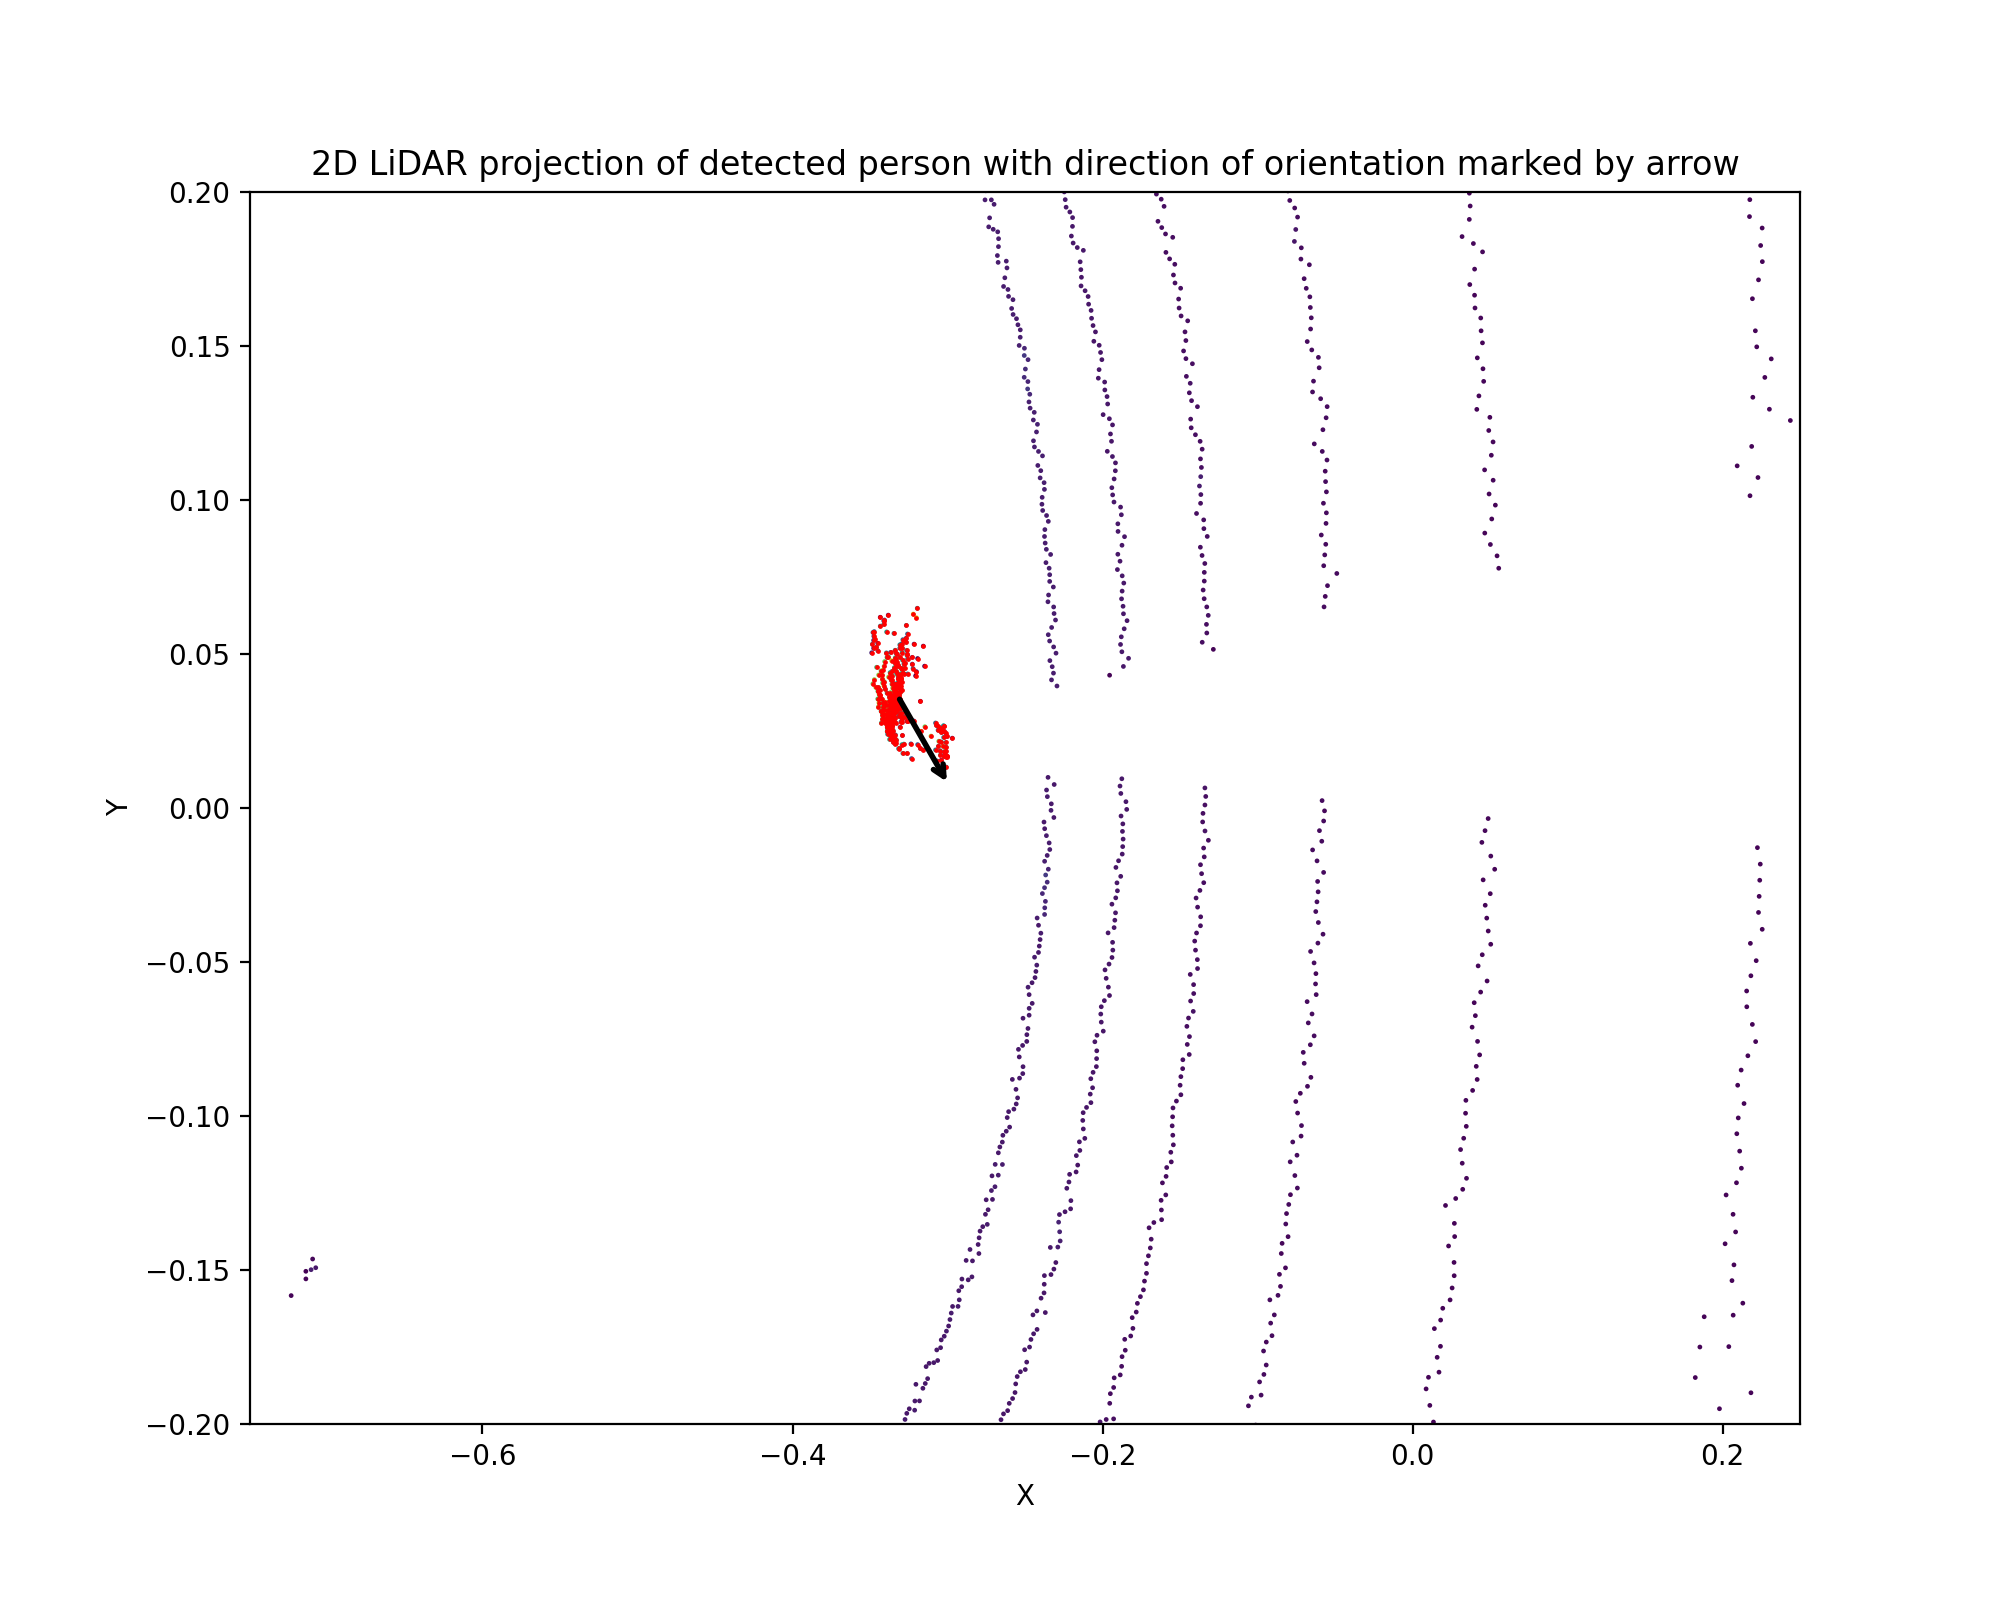

[ 0.03048793 -0.02680036]
Saving figure in /home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/person166_1/plots


In [31]:
 def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
%matplotlib notebook
%matplotlib notebook

# plot data
f2 = plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=2, s=0.5, c=temp_data[:, 3], cmap='viridis')
plt.scatter(X_temp[:, 0], X_temp[:, 1], s=0.5, c='r')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-0.75,0.25)
plt.ylim(-0.2,0.2)
plt.title("2D LiDAR projection of detected person with direction of orientation marked by arrow")


for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    print(v)
    draw_vector(pca.mean_, pca.mean_ + v)
# plt.axis('equal')
plt.show()
save_fig_in_folder(f2, path, keyword='orientation')

## Validation Pipeline

In [14]:
%matplotlib inline
for folder in sorted(os.listdir(DATA_DIR)):
    if folder.startswith('person'):
        print('---------------------')
        print(folder)
        path = os.path.join(DATA_DIR, folder) 
        data_files = [str(f) for f in sorted(os.listdir(path)) if f.endswith('.h5')] 
            
        # create subdirectory to save plots 
        SAVE_DIR = os.path.join(path, 'plots')
        if os.path.exists(SAVE_DIR):
            pass # File has already been processed
        else:
            os.makedirs(SAVE_DIR)
            
        # downsample frames 
        frame_sample = data_files[::20]
        print('Validating {}/{} frames'.format(len(frame_sample), len(data_files)))
        
        for frame in frame_sample: 
            # load data 
            f = os.path.join(path, frame)
            data, bbox = load_h5(f)
            # calculate bounding box on labeled data 
            box8 = calc_3d_box(bbox)
            gt_box = np.reshape(box8, (-1,8,3))
            detections_proj = display_bboxes_in_data(data, gt_box, plot=False)
            
            frame_name = str.rstrip(frame, '.h5')
            save_fig(detections_proj, os.path.join(SAVE_DIR, frame_name), extension='.png')
            plt.close('all')

---------------------
person166_1
Validating 12/225 frames
---------------------
person166_10
Validating 11/211 frames
---------------------
person166_11
Validating 10/198 frames
---------------------
person166_12
Validating 11/206 frames
---------------------
person166_13
Validating 11/209 frames
---------------------
person166_14
Validating 11/219 frames
---------------------
person166_15
Validating 11/204 frames
---------------------
person166_16
Validating 11/219 frames
---------------------
person166_17
Validating 11/212 frames
---------------------
person166_18
Validating 11/218 frames
---------------------
person166_19
Validating 11/216 frames
---------------------
person166_2
Validating 11/215 frames
---------------------
person166_20
Validating 12/228 frames
---------------------
person166_3
Validating 11/209 frames
---------------------
person166_4
Validating 11/201 frames
---------------------
person166_5
Validating 11/211 frames
---------------------
person166_6
Validating 

## Data Overview

In [28]:
data.shape

(4912377, 6)

In [29]:
data.head()

,rosbagTimestamp,x,y,z,intensity,time
0,1590775583702332952,-1.055055,1.817870,-0.563190,6.0,-0.048886
1,1590775583702332952,-3.424826,5.905756,0.119165,42.0,-0.048884
2,1590775583702332952,-1.224575,2.112502,-0.563727,4.0,-0.048882
3,1590775583702332952,-3.431576,5.924548,0.358815,26.0,-0.048879
4,1590775583702332952,-1.482979,2.562392,-0.575480,1.0,-0.048877


In [43]:
# investigate value ranges
x_max, x_min = np.max(data.x), np.min(data.x)
y_max, y_min = np.max(data.y), np.min(data.y)
z_max, z_min = np.max(data.z), np.min(data.z)
intensity_max, intensity_min = np.max(data.intensity), np.min(data.intensity)

print('x_max: {:.3f}, x_min: {:.3f}'.format(x_max, x_min))
print('y_max: {:.3f} y_min: {:.3f}'.format(y_min, y_max))
print('z_max: {:.3f}, z_min: {:.3f}'.format(z_max, z_min))
print('intensity_max: {:.3f}, intensity_min: {:.3f}'.format(intensity_max, intensity_min))
print('\nNumber of points: {}'.format(data.shape[0]))

x_max: 49.444, x_min: -4.745
y_max: -37.609 y_min: 35.406
z_max: 4.689, z_min: -1.359
intensity_max: 131.000, intensity_min: 0.000

Number of points: 3908367


In [95]:
data.z.mean()

0.46101681533919564

## Backup

### Create PCD Files 

In [30]:
timesteps = data.rosbagTimestamp.unique()
path = bag_dir + '/' + dropdown.value
os.mkdir(path)
thresh = 0 
for i,t in enumerate(timesteps):    
    # Analyze pointcloud from timestamp chosen above 
    oneframe_data = data[data.rosbagTimestamp == t].reset_index(drop=True)
    # Rotate & translate points to compensate for LiDAR tilt angle 
    oneframe_data_trans = df_apply_rot(oneframe_data, quat, return_full_df=True)
    oneframe_data_trans = translate_height(oneframe_data_trans, z_trans)
    # Remove ground points
    oneframe_data_trans_no_floor = remove_ground_points(oneframe_data_trans, thresh)
    # Filter by radius 
    oneframe_data_trans_no_floor = add_polar_coord(oneframe_data_trans_no_floor)
    label_mask = oneframe_data_trans_no_floor.r.between(*interval)
    oneframe_data_trans_no_floor['label'] = label_mask
    # Create template 
    template = oneframe_data_trans_no_floor[oneframe_data_trans_no_floor.label].reset_index(drop=True)
    # Save as binary matrix file for annotation
    temp_frame = template[['x','y','z']].copy()
#     temp = temp_frame.to_numpy(dtype='float32').astype('float32')
    temp = temp_frame.to_numpy()
    p = pcl.PointCloud(np.array(temp, dtype=np.float32))
    p.to_file(path + '/frame_{}_{}.pcd'.format(i,t))
#     temp.tofile(path + '/frame{}.bin'.format(t),  format="%f")

### Visualizations

#### 3D Plot using matplotlib

In [ ]:
%matplotlib notebook

In [ ]:
plot_pointcloud3d(start)

#### 3D Plot using pptk
See documentation [here](https://heremaps.github.io/pptk/index.html). 
Example screenshot of interactive 3D visualzation:
<img src="files/pcl_1585676368204491882.png">

In [113]:
import pptk

In [43]:
v = pptk.viewer(template_no_floor[['x', 'y', 'z']]) 
v.attributes(template_no_floor['intensity'])
v.set(point_size=0.01)

In [ ]:
v.capture('/home/brudermueller/Downloads/pcl_{}.png'.format(str(timesteps[0])))

In [139]:
# take only every 40th timestep
subsample = timesteps[::40]

In [ ]:
pcl = data[data.rosbagTimestamp == timesteps[150]].reset_index()
pcl = df_apply_rot(pcl)
pcl = remove_ground_points(pcl, -0.38)
pcl.head()
pcl = pcl[(pcl.x.between(2.9, 3.5)) & (pcl.y.between(-1, 2))]
v = pptk.viewer(pcl[['x', 'y', 'z']]) 
v.attributes(pcl['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=7)   

In [55]:
# save screenshot of lidar 3D plot for each timestep 
import time
templates = data_trans[data_trans.label].reset_index(drop=True)
# templates = data_trans_no_floor[data_trans_no_floor.label].reset_index(drop=True)

# templates = remove_ground_points(templates, 0)
for i,t in enumerate(timesteps[::10]): 
    pcl = templates[templates.rosbagTimestamp == t].reset_index(drop=True)
    if pcl.empty:
        print t
        continue
    v = pptk.viewer(pcl[['x', 'y', 'z']]) 
    v.attributes(pcl['intensity'])
    v.set(point_size=0.01, lookat=(4.5, -0.5, -1), r=10)    
    time.sleep(2)
#     v.capture('/home/brudermueller/Downloads/med/pcl_templates_{}_{}.png'.format(dropdown.value, i))
#     time.sleep(2)
    v.close()

In [ ]:
v = pptk.viewer(start_ground[['x', 'y', 'z']]) 
v.attributes(start_ground['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)

In [ ]:
v = pptk.viewer(start[['x', 'y', 'z']]) 
v.attributes(start['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)